**Setup iniziale**

In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.utils import check_random_state

from google.colab import drive
drive.mount('/content/drive')
cwd= 'drive/MyDrive/Colab Notebooks'
file_path= cwd + '/air_quality.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The CSV file was not found at the path: {file_path}")

# Carichiamo il dataset
# -> nrows indica il numero di righe massimo da caricare (qua ne carichiamo 300.000 per cercare di avere nel dataframe almeno 5 possibili classi di 'status')
# -> na_values contiene le stringhe del file che indicano valori assenti nelle celle (Pandas li sostituisce con un valore None)
df = pd.read_csv(file_path, low_memory=False, na_values=['-', 'NA', 'n/a', 'ND',''], nrows=1000000)

# Qua faremo clustering: la feature su cui faremo il mapping dei cluster è 'status'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data cleaning**

In [15]:
# Puliamo il dataset

# Eliminiamo dal dataset le colonne non necessarie al clustering: quelle non numeriche ed anche 'aqi' perché è strettamente correlata a 'status'
# Non togliamo 'status' perché la useremo poi per vedere la precisione del modello e per fare il mapping dei cluster
df.drop(columns=["sitename", "county", 'aqi', "siteid", "pollutant", "date"], errors='ignore', inplace=True)
# La funzione dropna() usa questi parametri:
# -> "axis" indica: 0=righe / 1=colonne [default: '0']
# -> "how" indica: 'all'="se tutti i valori sono nulli" / 'any'="se almeno un valore è nullo" [default: 'any']
# -> "subset" indica di considerare solo i valori di certe colonne quando deve verificare se sono nulli
# -> "inplace=True" dice a Pandas di fare la modifica direttamente sull'oggetto (quindi le funzioni ritorneranno None)
# ELIMINIAMO PRIMA LE COLONNE VUOTE E POI LE RIGHE: altrimenti vengono eliminate tutte le righe perché la colonna 'unit' è completamente vuota
df.dropna(axis=1, how='all', inplace=True) # Eliminiamo tutte le colonne che hanno tutti valori None (SOLO VALORI NULLI)
df.dropna(axis=0, how='any', inplace=True) # Eliminiamo tutte le righe che hanno almeno un valore None in un campo qualsiasi

**Pre-processing**

In [16]:
# Selezioniamo i nomi delle colonne numeriche
numeric_cols_names= df.select_dtypes(include=[np.number]).columns.tolist()

# Facciamo lo scaling dei valori presenti nelle colonne numeriche del dataset
scaler= StandardScaler()
df[numeric_cols_names]= scaler.fit_transform(df[numeric_cols_names])

# Calcoliamo quante classi di 'status' sono presenti nel dataset (creeremo un numero di cluster pari al numero di classi)
num_clusters= len(df['status'].unique())

**Model building e valutazione delle performance**

In [ ]:
# Creiamo il modello con KMeans e gli diciamo di trovare "n_cluster=num_clusters" cluster dai dati che gli daremo
kmeans= KMeans(n_clusters=num_clusters, random_state=42) # Ricordiamo che abbiamo 5 classi possibili di 'status' (quindi cercherà 5 cluster)
# Addestriamo il modello sulle colonne numeriche standardizzate con lo StandardScaler per trovare i cluster, poi assegnamo ogni riga del dataset ad un cluster
# I cluster sono identificati da un numero intero, quindi "labels" sarà un array che contiene per ogni riga del dataset il numero corrispondente al proprio cluster
labels= kmeans.fit_predict(df[numeric_cols_names])

# Visualizziamo il risultato del clustering in una crosstab, ovvero una matrice, che mostra:
# -> sulle righe le classi di 'status'
# -> sulle colonne i cluster trovati identificati da un numero
# Ogni cella contiene il numero di elementi di una certa classe di 'status' che rientrano in un certo cluster
crosstab= pd.crosstab(df['status'], labels, colnames=['cluster'])
print("Crosstab:")
display(crosstab)   #python vuole print

# In questo momento i cluster sono solo dei numeri e non sono ancora collegati a delle classi di 'status': per ogni cluster calcoliamo qual'è la classe più presente
# al suo interno e lo colleghiamo ad essa facendo un mapping
cluster_to_status= crosstab.idxmax(axis=0).to_dict()
print("Mapping cluster --> status: ", cluster_to_status)

# Convertiamo gli identificativi numerici dei cluster presenti in "labels" con il nome della classe di 'status' corrispondente inserendoli in una serie Pandas con lo
# stesso ordine di indici di "df", che a sua volta inseriamo in "pred_status"
pred_status= pd.Series(labels, index=df.index).map(cluster_to_status)

# Creiamo una serie Pandas "is_correct" di booleani dove per ogni elemento di "pred_status" inseriamo "True/False" in base a se matcha o no con la classe reale
is_correct= pred_status.eq(df['status'])

# Creiamo un dataframe "summary" dove mettiamo i risultati sulle performance
summary= (
    # Creiamo un nuovo dataframe dove mettiamo:
    # -> una colonna 'status' con tutti gli status del dataframe originale nello stesso ordine
    # -> una colonna 'correct' con tutti gli elementi booleani di "is_correct" nello stesso ordine
    # In questo modo ogni riga del nuovo dataframe dice se la sua classe di 'status' rientra nel cluster mappato sulla stessa classe
    pd.DataFrame({'status': df['status'], 'correct': is_correct})
    # Raggruppiamo per 'status' ed all'interno di ogni gruppo selezioniamo la colonna 'correct'
    .groupby('status')['correct']
    # Per ogni gruppo di 'status':
    # -> sommiamo tutti gli elementi della colonna 'correct' (True=1 / False=0)
    # -> creiamo una nuova colonna 'tot' dove contiamo il numero di righe totali
    # Per ogni gruppo di 'status' otteniamo quindi una riga fatta così:
    # |status| |correct| |tot|
    # Infine, uniamo tutte le righe ottenute in un dataframe finale che mettiamo dentro a "summary"
    .agg(correct='sum', tot='count')
    # Il risultato è ad esempio così:
    # |  status  | |correct| |  tot  |
    # |   Good   | | 12000 | | 15000 |
    # | Moderate | | 10500 | | 10000 |
    # ... eccetera
)

# Aggiungiamo al dataframe "summary" una colonna 'incorrect' dove mettiamo per ogni riga il numero di elementi che sono stati messi in un cluster che non matcha con
# la loro classe di 'status'
summary['incorrect']= summary['tot'] - summary['correct']
# Aggiungiamo al dataframe "summary" una colonna 'accuracy_%' dove mettiamo per ogni riga la % di elementi che sono nel cluster corretto
summary['accuracy_%']= (summary['correct'] / summary['tot'] * 100).round(2)

# Visualizziamo le performance contenute in "summary"
print("Performance per ogni classe di 'status':")
display(summary)

# Calcoliamo e mostriamo la media globale di precisione (media dei valori di "is_correct")
overall_acc= is_correct.mean()
print(f"Accuracy globale (cluster --> status): {overall_acc*100:.2f}%")

Crosstab:


cluster,0,1,2,3,4
status,,,,,
Good,235469,5774,263418,49249,16326
Moderate,32114,99733,17104,115937,19726
Unhealthy,0,1146,0,377,27
Unhealthy for Sensitive Groups,14,23232,6,6205,1360
Very Unhealthy,0,0,0,3,0


Mapping cluster --> status:  {0: 'Good', 1: 'Moderate', 2: 'Good', 3: 'Moderate', 4: 'Moderate'}
Performance per ogni classe di 'status' (correct/incorrect/accuracy):


,correct,tot,incorrect,accuracy_%
status,,,,
Good,498887,570236,71349,87.49
Moderate,235396,284614,49218,82.71
Unhealthy,0,1550,1550,0.00
Unhealthy for Sensitive Groups,0,30817,30817,0.00
Very Unhealthy,0,3,3,0.00


Accuracy globale (cluster --> status): 82.76%


**Visualizzazione 2D dei cluster**

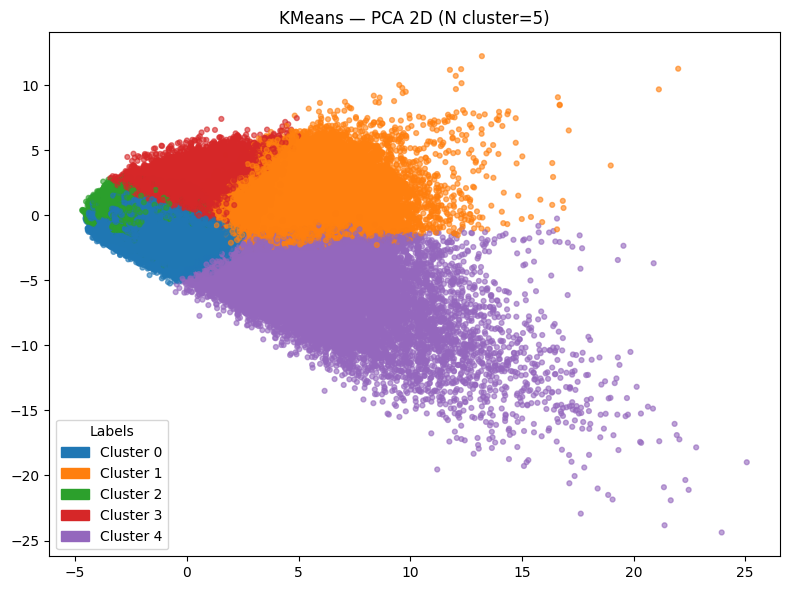

In [ ]:
# Per graficare in 2D tutte le feature numeriche usate nel clustering utilizziamo PCA che le compressa in sole "n_components=2" componenti
pca= PCA(n_components=2)
compressed_features= pca.fit_transform(df[numeric_cols_names])

# Selezioniamo la base di colori "tab10"
base_cmap= plt.colormaps["tab10"]
# Selezioniamo solo i primi "num_clusters" colori di "tab10"
colors= base_cmap.colors[:num_clusters]
# Creiamo una mappa dove assegnamo ogni colore ad un numero
cmap= ListedColormap(colors)

# Usiamo Matplotlib per disegnare il grafico con i cluster
plt.figure(figsize=(8,6))
sc1= plt.scatter(
    compressed_features[:,0], compressed_features[:,1],
    c=labels,
    cmap=cmap, # Il colore di ogni cluster è basato sull'identificativo del cluster
    alpha=0.6, # Formattazione disegno
    s=12 # Formattazione disegno
)
# Creiamo una lista con i numeri identificativi dei cluster presi singolarmente
clusters_id= np.unique(labels)
# Assegnamo ad ogni cluster un colore diverso
colors= [cmap(i) for i in range(num_clusters)]
patches= [mpatches.Patch(color=colors[i], label=f'Cluster {cl}') for i, cl in enumerate(clusters_id)]
# Aggiungiamo la legenda al disegno
plt.legend(handles=patches, title="Labels", loc='lower left', frameon=True)
# Mostriamo il titolo
plt.title(f'KMeans — PCA 2D (N cluster={num_clusters})')
plt.tight_layout() # Formattazione disegno
plt.show()